In [1]:
using LaTeXStrings
using HDF5
using PyPlot
using PyCall
using Photochemistry

In [2]:
include("PARAMETERS.jl");

In [3]:
function flux_pos_and_neg(fluxarr)
    pos = []
    neg = []

    for f in fluxarr
        if f > 0
            append!(pos, f)
            append!(neg, NaN)
        else
            append!(neg, abs(f))
            append!(pos, NaN)
        end
    end
    return pos, neg
end

# this is loaded here just to make sure we are getting the right boundary condition.

function get_flux_testing(ncur, species::Symbol, controltemps::Array, thebclist)
    thesecoefs = [fluxcoefs(a, dz, species, ncur, controltemps) for a in non_bdy_layers] 

    bcs = boundaryconditions(species, dz, ncur, controltemps, thebclist)
    println(bcs)
    
    net_bulk_flow = fill(convert(Float64, NaN), length(alt)-1)  # units #/cm^3/s; tracks the cell boundaries, of which there are length(alt)-1
    net_bulk_flow[1] = (bcs[1, 2]  # increase of the lowest atmospheric layer's density. Will always be 0 unless the species has a density or flux condition
                       - ncur[species][1]*bcs[1, 1]) # lowest atmospheric layer --> surface ("depositional" term)
                        
    for ialt in 2:num_layers  # now iterate through every cell boundary within the atmosphere. boundaries at 3 km, 5...247. 123 elements.
        net_bulk_flow[ialt] = (ncur[species][ialt-1]*thesecoefs[ialt-1][2]   # coming up from below: cell i-1 to cell i
                              - ncur[species][ialt]*thesecoefs[ialt][1])     # leaving to the layer below: downwards: cell i to cell i-1
    end
    net_bulk_flow[end] = (ncur[species][end]*bcs[2, 1] # into exosphere from the cell
                         - bcs[2, 2]) # into top layer from exosphere. do not question this
                
    return net_bulk_flow .* dz # now it is a flux. hurrah.
end

get_flux_testing (generic function with 1 method)

In [4]:
# Load the minimum stuff we need to establish speciesbclist, which is necessary for plot_rxns and such
global T_surf = meanTs
global T_tropo = meanTt
global T_exo = meanTe
Temp_n(z::Float64) = T_all(z, meanTs, meanTt, meanTe, "neutral")
H2Osat = map(x->Psat(x), map(Temp_n, alt)) # array in #/cm^3 by altitude
HDOsat = map(x->Psat_HDO(x), map(Temp_n, alt))

global const speciesbclist=Dict(
                :CO2=>["n" 2.1e17; "f" 0.],
                :Ar=>["n" 2.0e-2*2.1e17; "f" 0.],
                :N2=>["n" 1.9e-2*2.1e17; "f" 0.],
                :H2O=>["n" H2Osat[1]; "f" 0.], # bc doesnt matter if H2O fixed
                :HDO=>["n" HDOsat[1]; "f" 0.],
                :O=>["f" 0.; "f" 1.2e8],
                :H2=>["f" 0.; "v" effusion_velocity(Temp_n(zmax), 2.0, zmax)],  # velocities are in cm/s
                :HD=>["f" 0.; "v" effusion_velocity(Temp_n(zmax), 3.0, zmax)],
                :H=>["f" 0.; "v" effusion_velocity(Temp_n(zmax), 1.0, zmax)],
                :D=>["f" 0.; "v" effusion_velocity(Temp_n(zmax), 2.0, zmax)],
                # TODO: Ion boundary conditions?
               );

# Escape timescale

In [23]:
ncur_nom = get_ncurrent("/home/emc/GDrive-CU/Research-Modeling/UpperAtmoDH/Code/converged_full_ionosphere.h5")
ncur_extraD = deepcopy(ncur_nom)
extraD_start_alt = 184 # in km
 
added_D = map(x->1e5*exp(-((x-extraD_start_alt)/20)^2), non_bdy_layers/1e5)
ncur_extraD[:D] = ncur_nom[:D] + added_D

124-element Array{Float64,1}:
   49.23884822494022
   65.81903683740313
   89.18444522458843
  122.72092203490557
  171.92854864395082
  245.59422390841104
  357.6494240447237
  529.7047944923428
  794.195692727072
 1198.1468626269739
 1807.1486331117098
 2701.1282949257115
 3846.200188252342
    ⋮
 8314.939123975975
 7834.115847264033
 7492.2726112416485
 7248.551480622121
 7072.453569289923
 6941.894467838437
 6841.338907200143
 6760.1577517935375
 6691.270664138783
 6630.081824329626
 6573.682023572287
 6520.273857191176

In [6]:
fluxD_nom = get_flux_testing(ncur_nom, :D, [216., 130., 205.], speciesbclist)

[0.0 -0.0; 2.59430997738397e-6 0.0]


125-element Array{Float64,1}:
    -0.0
  -132.23377053384294
  -184.0943667290333
  -260.77805623208377
  -377.10807258340236
  -556.4226934695687
  -835.5578201604375
 -1270.5422834543463
 -1942.7555219115904
 -2965.968446064703
 -4492.080739201084
 -6671.263142764261
 -8967.936706330325
     ⋮
  3052.5325011694804
  3087.2444214764982
  3120.4666738631204
  3152.4355174042284
  3183.3493761951104
  3213.3748318301514
  3242.651419714093
  3271.2959015043452
  3299.4056498864666
  3327.061707386747
  3354.3309895321727
  3381.2693005544647

In [7]:
fluxD_boostD = get_flux(ncur_extraD, :D, [216., 130., 205.], speciesbclist)

125-element Array{Float64,1}:
    -0.0
  -132.23377053384294
  -184.0943667290333
  -260.77805623208377
  -377.10807258340236
  -556.4226934695687
  -835.5578201604375
 -1270.5422834543463
 -1942.7555219115904
 -2965.968446064703
 -4492.080739201084
 -6671.263142764261
 -8967.936706330325
     ⋮
     1.2131210708696365e9
     8.424907335620228e8
     5.714566737490327e8
     3.786933669166057e8
     2.4524134972725004e8
     1.5524047964827332e8
     9.607605920606875e7
     5.814462830185658e7
     3.441652104218665e7
     1.9927913842655834e7
     1.128933043848665e7
  3383.1223045973866

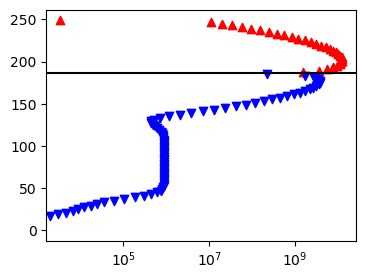

186


In [8]:
upflux, downflux = flux_pos_and_neg(fluxD_boostD) # get arrays of the upward flux and arrays of the downward flux
firstnonnan = findfirst(!isnan, upflux)
updownline = Int(alt[firstnonnan]/1e5)
println(updownline)

# Plot the flux to make sure we are good
figure(figsize=(4,3))
scatter(upflux, collect(1:2:249), color="red", marker="^")
scatter(downflux, collect(1:2:249), color="blue", marker="v")
axhline(updownline, color="black")
xscale("log")

In [9]:
flux_D_to_space = fluxD_boostD[end]  # we are only concerned with the flux into space, not the flux through any other layer.
# Next line is the column abundance (#/cm^2) of the D that was ADDED to the atmosphere and is also above the level at which the flux is upwards.
n_D_tot = sum(added_D[firstnonnan:end]) * dz  
println(n_D_tot)
println(flux_D_to_space)
escape_timescale = n_D_tot / flux_D_to_space
escape_timescale_min = escape_timescale * (1/3600) * (1/24) # days

1.4744363963257895e11
3383.1223045973866


504.4226762182161

#  Diffusion timescale

This calculation of the diffusion timescale is with the scale height H and diffusion coefficient D calculated only at the altitude at which extra D is injected into the atmosphere.

In [56]:
# 1st way: H and D calculated only at the altitude at which D is injected.
H_D = scaleH(extraD_start_alt*1e5, :D, [216., 130., 205.]) # in cm 
n_tot_atalt = n_tot(ncur_extraD, extraD_start_alt*1e5)
T_atalt = T_all(extraD_start_alt*1e5, 216., 130., 205., "neutral")
D_D_atalt = Dcoef(T_atalt, n_tot_atalt, :D)

transport_timescale = (H_D^2)/D_D_atalt 
transport_timescale_min = transport_timescale * (1/60) # in minutes
printfmt("Timescale (simple): {:.1f} min", transport_timescale_min)

Timescale (simple): 66.2 min

This version of the calculation takes into account the fact that H and D vary with altitude, so that at every layer of the atmosphere, the given D atom will have a different timescale to traverse that slice of the atmosphere (2 km wide)

In [57]:
# second way: Array of diffusion coefficients and n_tot.
# get the scale height H, n_tot, the temperature T, and the diffusion coefficient D at each layer of the atmosphere. 
H_array = map(z->scaleH(z, :D, [216., 130., 205.]), alt) # in cm 
n_tot_array = map(z->n_tot(ncur_extraD, z), alt)
T_array = map(z->T_all(z, 216., 130., 205., "neutral"), alt)
D_array = [Dcoef(T, n, :D) for (T, n) in zip(T_array, n_tot_array)]

# Find the indices in the altitude array at which extra D is injected and for 80 km,
# which I have arbitrarily picked to be the altitude at which I imagine D is "mixed down."
i_D = n_alt_index[extraD_start_alt*1e5]
i_mixed = n_alt_index[80*1e5]

# Timescale calculated with the physical dimension represented by the width of an atmospheric slice, 2 km, since that's how the D array is discretized.
timescale_to_80km = sum((2e5)^2 ./ D_array[i_mixed:i_D]) / 3600 
printfmt("Timescale (discretized): {:.2f} hours", timescale_to_80km)
println()

# Timescale in hours but with the length dimension being the discretized scale height which I don't think is right.
timescale_to_80km_maybewrong = sum((H_array[i_mixed:i_D].^2) ./ D_array[i_mixed:i_D]) * (1/3600) * (1/24) * (1/687)
printfmt("Timescale (using discretized H): {:.2f} Mars years", timescale_to_80km_maybewrong)
println()


Timescale (discretized): 121.64 hours
Timescale (using discretized H): 42.57 Mars years


# Calculate how much D escapes and how much diffuses

In [13]:
fluxD_nominal = get_flux(ncur_nom, :D, [216., 130., 205.], speciesbclist)

println(fluxD_nominal[end])
pos_nominal, neg_nominal = flux_pos_and_neg(fluxD_nominal);

3381.2693005544647


In [14]:
# Gather the flux of D arrays for each step of the simulation where we add extra D.
filestrs = ["0.001", "0.01", "0.1", "1.0", "10.0", "100.0", "1000.0", "10000.0", "100000.0", "1.0e6"]

fluxD = fill(NaN, length(filestrs), 125)  # 125 is the number of boundaries in the model.
i = 1

for s in filestrs
    ncur = get_ncurrent("/home/emc/GDrive-CU/Research-Modeling/UpperAtmoDH/Results/extra_D/ncurrent_$(s).h5");
    fluxD[i, :] = get_flux(ncur, :D, [216., 130., 205.], speciesbclist)
    i += 1
end


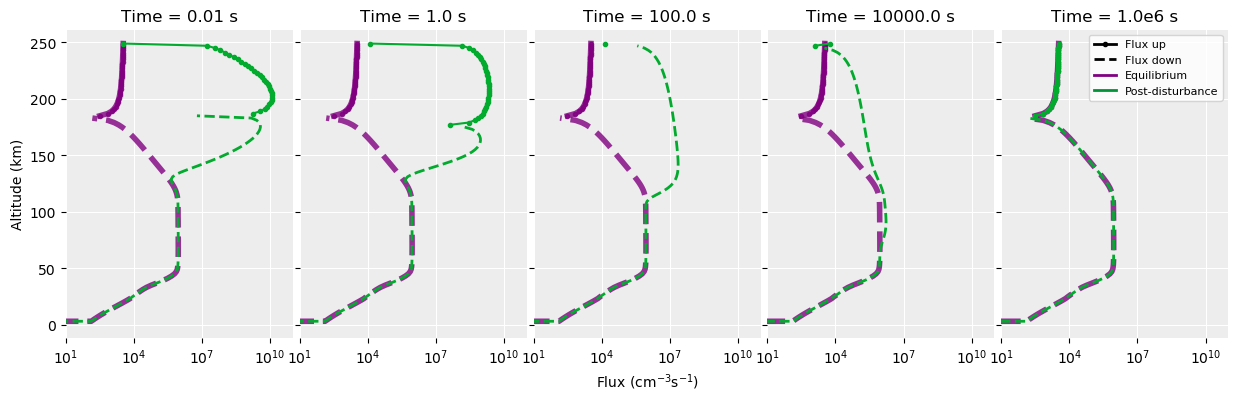

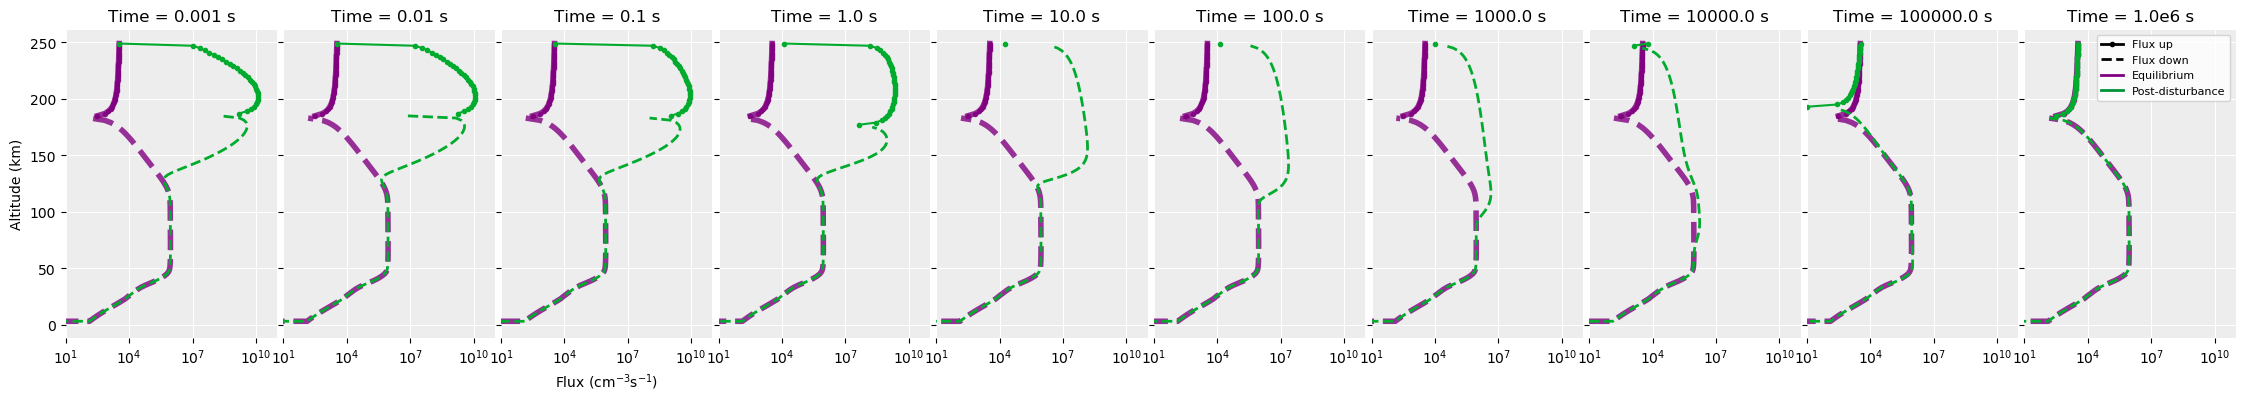

In [15]:
# make a plot showing the flux at every other timestep (so the plot isn't too huge)
fig, ax = subplots(1, Int(size(fluxD)[1]/2), sharey=true,sharex=true,figsize=(15,4))
subplots_adjust(wspace=0.03)
for i in 2:2:size(fluxD)[1]
    ax_num = Int(i/2)
    plot_bg(ax[ax_num])
    ax[ax_num].set_xlim(1e1, 1e11)
    ax[ax_num].set_xscale("log")
    ax[ax_num].plot(pos_nominal, collect(1:2:249), color="purple", marker=".", linewidth=4, zorder=10, alpha=0.8)
    ax[ax_num].plot(neg_nominal, collect(1:2:249), color="purple", linestyle="--", linewidth=4,  zorder=10, alpha=0.8)
    
    p, n = flux_pos_and_neg(fluxD[i, :])
    ax[ax_num].plot(p, collect(1:2:249), color="xkcd:kelly green", marker=".", zorder=10)
    ax[ax_num].plot(n, collect(1:2:249), color="xkcd:kelly green", linewidth=2, linestyle="--", zorder=10)
    ax[ax_num].set_title("Time = $(filestrs[i]) s")
end

ax[3].set_xlabel(L"Flux (cm$^{-3}$s$^{-1}$)")
ax[1].set_ylabel("Altitude (km)")
L2D = PyPlot.matplotlib.lines.Line2D
lines = [L2D([0], [0], color="black", linewidth=2, marker=".", linestyle="-"),
         L2D([0], [0], color="black", linewidth=2, linestyle="--"),
         L2D([0], [0], color="purple", linewidth=2, linestyle="-"), 
         L2D([0], [0], color="xkcd:kelley green", linewidth=2, linestyle="-")]
labels = ["Flux up", "Flux down", "Equilibrium", "Post-disturbance"]
legend(lines, labels, fontsize=8)
savefig("flux_progression.png", bbox_inches="tight")

# The same plot, but with all the panels. 
fig, ax = subplots(1, Int(size(fluxD)[1]), sharey=true,sharex=true,figsize=(28,4))
subplots_adjust(wspace=0.03)
for i in 1:size(fluxD)[1]
    plot_bg(ax[i])
    ax[i].set_xlim(1e1, 1e11)
    ax[i].set_xscale("log")
    ax[i].plot(pos_nominal, collect(1:2:249), color="purple", marker=".", linewidth=4, zorder=10, alpha=0.8)
    ax[i].plot(neg_nominal, collect(1:2:249), color="purple", linestyle="--", linewidth=4,  zorder=10, alpha=0.8)
    
    p, n = flux_pos_and_neg(fluxD[i, :])
    ax[i].plot(p, collect(1:2:249), color="xkcd:kelly green", marker=".", zorder=10)
    ax[i].plot(n, collect(1:2:249), color="xkcd:kelly green", linewidth=2, linestyle="--", zorder=10)
    ax[i].set_title("Time = $(filestrs[i]) s")
end

ax[3].set_xlabel(L"Flux (cm$^{-3}$s$^{-1}$)")
ax[1].set_ylabel("Altitude (km)")
L2D = PyPlot.matplotlib.lines.Line2D
lines = [L2D([0], [0], color="black", linewidth=2, marker=".", linestyle="-"),
         L2D([0], [0], color="black", linewidth=2, linestyle="--"),
         L2D([0], [0], color="purple", linewidth=2, linestyle="-"), 
         L2D([0], [0], color="xkcd:kelley green", linewidth=2, linestyle="-")]
labels = ["Flux up", "Flux down", "Equilibrium", "Post-disturbance"]
legend(lines, labels, fontsize=8)
savefig("flux_progression_full.png", bbox_inches="tight")

In [16]:
using Formatting

# Get the total added D
total_D_percm3 = sum(map(x->1e5*exp(-((x-184)/20)^2), non_bdy_layers/1e5))
total_added_D_percm2 = total_D_percm3 * dz

# Get arrays of the times and the EXCESS flux (the flux for each simulation, minus nominal)
times = [parse(Float64, f) for f in filestrs]
total_flux_per_s = fluxD[:, end]
total_excess_flux_per_s = total_flux_per_s .- fluxD_nominal[end]

# Now we use these arrays and integrate in python (because I can't quickly find a way to integrate these in Julia)
println(times)
println(total_excess_flux_per_s)
println()

# The result from Python for total excess flux of D out of the atmosphere is  this value in #/cm^2.
total_excess_D_flux = 2.00085755e8

printfmt("Total D added to the atmosphere: {:.3e}", total_added_D_percm2)
println()
printfmt("Total excess D flux to space: {:.2e}", total_excess_D_flux)
println()
printfmt("That leaves {:.3e} D diffused down into the atmosphere.", total_added_D_percm2 - total_excess_D_flux)

[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1.0e6]
[2.2821324829610603, 7.521132613374448, 363.3682993379002, 9180.325121268588, 13883.23209124, 10289.252694209437, 6635.110452073766, 2367.0916738786223, 90.87325212969836, -1.6385826840901245]

Total D added to the atmosphere: 3.545e+11
Total excess D flux to space: 2.00e+08
That leaves 3.543e+11 D diffused down into the atmosphere.